## Chemiluminescence-(extracting temperature at different positions for various velocities)

### Usage:
This code is used to determine the temperature at different positions for various velocities.

Quantify temperatures at individual locations (e.g. -2, 0, etc.), and plot results as a function of velocity.


In [1]:
import numpy as np
import pandas as pd
import glob

import matplotlib.pylab as plt
%matplotlib inline
#%config InlineBackend.figure_formats = ["retina"]
from scipy.optimize import curve_fit
import microfit.database as db
import microfit.hdr as hdr
import microfit.chemiluminescence as chem
import microfit.pyrometry as pyro
#import microfit.analysis as anls
from microfit import analysis
from scipy import stats
from matplotlib.pyplot import figure
import pywt as pw
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
import math
#from scipy import opQtimize as opt
from importlib import reload
import matplotlib.gridspec as gsp
from  matplotlib.ticker import MultipleLocator
import matplotlib as mpl
import warnings
warnings.filterwarnings(action='once')
#warnings.filterwarnings(action='error')

<Figure size 640x480 with 0 Axes>

In [2]:
plt.style.use('../manuscript.mplstyle')
plt.rcParams['figure.figsize']

[8.0, 5.5]

In [3]:
show = True

In [4]:
xlsx = '../index_2018_02_PRF_data.xlsx'
df = pd.read_excel(xlsx)

C:\Users\Navid\Miniconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():





### Select Data for Gaseous Fuels

In [5]:
cases = np.unique(df.case)
cases = [ c for c in cases if c=='2020_01_28_PRF60_57.8psig_10.00O2_1mm']
cases


['2020_01_28_PRF60_57.8psig_10.00O2_1mm']

In [6]:
ix = df.case.isin(cases)
rp = db.Database(df[ix],verbosity=2)

### Functions

In [7]:
#T: T array for mixture with flame
#x: x array for mixture with flame
#n: max level of decomposition by wavelet
#xl: min of x value for wavelet calculation
#xu : max of x value for wavelet calculation
def wv(T,x,n,xl,xu):
    q = []
    for i in range(4):
        i = n-2+i
        x1 = find_nearest_index(x,xl)
        x2 = find_nearest_index(x,xu)
        x_new = x[x1:x2-1]
        x_wv = wavelet_domain(x_new)
        T_new = T[x1:x2-1]
        ca = pw.wavedec(T_new,wtype,level=i)[0]
        x_wv, ca = equalize(x_wv, ca)
        f = np.column_stack((x_wv,ca))
        q = np.asarray(list(q) + list(f))
    sorted(q, key=lambda x: x[1])
    ca_new = [q[i][1] for i in range(len(q))]
    x_wv_new = [q[i][0] for i in range(len(q))]
    return ca_new, x_wv_new

In [8]:
def cf(x,c0,c1,c2,c3):
    return c0+c1*x+c2*x**2+c3*x**3
#initial guess for the coefficients
p0 = [ 1.16653367e+03,  3.63481158e+01, -2.95535009e+00,  7.99994392e-02]

Find nearest value index in numpy array

In [9]:
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

Returns the list with largest length

In [10]:
def max_size(array1, array2):
    if len(array1) >= len(array2):
        return array1
    else:
        return array2

Returns the list with smallest length

In [11]:
def min_size(array1, array2):
    if len(array1) >= len(array2):
        return array1
    else:
        return array2

In [12]:
def wavelet_domain(array):
    x = []
    for i in range(len(array)-1):
        if i%2==0:
            x.append((array[i]+array[i+1])/2)
        else:
            continue
    return x

In [13]:
x= [1,2,3,4,5,5,1,2]
xn =[]
for i in range(len(x)):
    if i <= len(x)-2:
        xn.append(x[i+1])
    else:
        continue
print(len(x))
print(xn)

8
[2, 3, 4, 5, 5, 1, 2]


In [14]:
x= [1,2,3,4,5,5,1,2]
for i in range(2):
    print(x[i])

1
2


In [15]:
def tpfinders(fs1,fs2,fs3,x1,x2,x3):
    x = []
    fsn = []
    for i in range(2):
        x.append(x1[i])
    x.append(x2[1])
    for i in range(len(x3)):
        if i <= len(x3)-2:
            x.append(x3[i+1])
        else:
            continue
    for i in range(2):
        fsn.append(fs1[i])
    fsn.append(fs2[1])
    for i in range(len(fs3)):
        if i <= len(fs3)-2:
            fsn.append(fs3[i+1])
        else:
            continue
    return fsn, x

In [16]:
def tpfinderfr(fs1,fs2,x1,x2):
    x = []
    fsn = []
    for i in range(3):
        x.append(x1[i])
    for i in range(len(x2)):
        if i <= len(x2)-3:
            x.append(x2[i+2])
        else:
            continue
    for i in range(3):
        fsn.append(fs1[i])
    for i in range(len(fs2)):
        if i <= len(fs2)-3:
            fsn.append(fs2[i+2])
        else:
            continue
    return fsn, x

In [17]:
def equalize(xpos,cd):
    x = len(xpos)
    y = len(cd)
    xpos = np.linspace(xpos[0],xpos[-1], y)
    return [xpos,cd] 


### Assignment of Temperature Profiles

In [18]:
z = [1,2,23,4,5346,67]
y = [2,3,3,3,3,3,4,4,3,3,3,3,3]

In [19]:
y

[2, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3]

In [20]:
seq1 = rp.find_sequence_by('case', phi=0)
seq1

{'2020_01_28_PRF60_57.8psig_10.00O2_1mm': 7}

In [21]:
seq2 = rp.find_sequence_by('case', phi=1)
seq2

{'2020_01_28_PRF60_57.8psig_10.00O2_1mm': [2,
  3,
  4,
  5,
  6,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15]}

In [22]:
rp.get_entries(seq1, 'v')

{'2020_01_28_PRF60_57.8psig_10.00O2_1mm': 8.0}

In [23]:
folder_name1 = str(cases[0])
print(folder_name1)

2020_01_28_PRF60_57.8psig_10.00O2_1mm


In [24]:
reload.__name__

'reload'

In [25]:
_ = reload(pyro)
_ = reload(analysis)

In [26]:
x_ext, x_max, x_ign = rp.get_x_flames(seq1)

Case: 2020_01_28_PRF60_57.8psig_10.00O2_1mm (C:\Users\Navid\1Notebooks_master\fuels\2020_01_28_PRF60_57.8psig_10.00O2_1mm)
 * get_x_flame -> PRF60_d76.2_v8.0_phi0.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)
    <load_raw> ... generate HDR calibration image: cube01_raw1.tif
    <load_raw> ... generate HDR image: PRF60_d76.2_v8.0_phi0.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)_raw1.tif
    <perform_analysis> ... creating new `Fourier` object
rejecting apparent diameter: 70.675
0.48046875 0.48046875
rejecting apparent diameter: 70.675
0.48046875 0.48046875
rejecting apparent diameter: 70.675
0.48046875 0.48046875
    <extract_filament> ... extracting `Fourier` filament
    <extract_temperature> ... creating `PyroFrame` object
    <load_raw> ... generate HDR calibration image: cube01_raw2.tif
    <load_raw> ... generate HDR image: PRF60_d76.2_v8.0_phi0.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)_raw2.tif
    <perform_analysis> ... creating new `Fourier` object
 

In [27]:
_, _ = rp.extract_temperatures(seq1)

Case: 2020_01_28_PRF60_57.8psig_10.00O2_1mm (C:\Users\Navid\1Notebooks_master\fuels\2020_01_28_PRF60_57.8psig_10.00O2_1mm)
 * extract_temperature -> PRF60_d76.2_v8.0_phi0.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results


In [28]:
_ = reload(chem)
_ = reload(analysis)

In [29]:
frames1 = rp.extract_flames(seq1,camera=2) #,force=True)

Case: 2020_01_28_PRF60_57.8psig_10.00O2_1mm (C:\Users\Navid\1Notebooks_master\fuels\2020_01_28_PRF60_57.8psig_10.00O2_1mm)
 * extract_flame -> PRF60_d76.2_v8.0_phi0.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
    <extract_filament> ... returning buffered filament
    <extract_flame> ... creating `FlameFrame` object


In [30]:
reload.__name__

'reload'

In [31]:
_ = reload(pyro)
_ = reload(analysis)

In [32]:
x_ext, x_max, x_ign = rp.get_x_flames(seq2)

Case: 2020_01_28_PRF60_57.8psig_10.00O2_1mm (C:\Users\Navid\1Notebooks_master\fuels\2020_01_28_PRF60_57.8psig_10.00O2_1mm)
 * get_x_flame -> PRF60_d76.2_v3.0_phi1.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)
    <load_raw> ... generate HDR image: PRF60_d76.2_v3.0_phi1.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)_raw1.tif
    <perform_analysis> ... creating new `Fourier` object
rejecting apparent diameter: 70.675
0.48046875 0.48046875
rejecting apparent diameter: 70.675
0.48046875 0.48046875
rejecting apparent diameter: 70.675
0.48046875 0.48046875
    <extract_filament> ... extracting `Fourier` filament
    <extract_temperature> ... creating `PyroFrame` object
    <load_raw> ... generate HDR image: PRF60_d76.2_v3.0_phi1.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)_raw2.tif
    <perform_analysis> ... creating new `Fourier` object
    <extract_filament> ... extracting `Fourier` filament
    <extract_flame> ... creating `FlameFrame` object
 * get_x_flame -> PRF60_d

    <extract_filament> ... extracting `Fourier` filament
    <extract_temperature> ... creating `PyroFrame` object
    <load_raw> ... generate HDR image: PRF60_d76.2_v12.0_phi1.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)_raw2.tif
    <perform_analysis> ... creating new `Fourier` object
    <extract_filament> ... extracting `Fourier` filament
    <extract_flame> ... creating `FlameFrame` object
 * get_x_flame -> PRF60_d76.2_v13.0_phi1.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)
    <load_raw> ... generate HDR image: PRF60_d76.2_v13.0_phi1.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)_raw1.tif
    <perform_analysis> ... creating new `Fourier` object
rejecting apparent diameter: 70.675
0.48046875 0.48046875
rejecting apparent diameter: 70.105
0.484375 0.484375
rejecting apparent diameter: 70.105
0.484375 0.484375
    <extract_filament> ... extracting `Fourier` filament
    <extract_temperature> ... creating `PyroFrame` object
    <load_raw> ... generate HDR image:

In [33]:
_, _ = rp.extract_temperatures(seq2)

Case: 2020_01_28_PRF60_57.8psig_10.00O2_1mm (C:\Users\Navid\1Notebooks_master\fuels\2020_01_28_PRF60_57.8psig_10.00O2_1mm)
 * extract_temperature -> PRF60_d76.2_v3.0_phi1.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> PRF60_d76.2_v4.0_phi1.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> PRF60_d76.2_v5.0_phi1.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> PRF60_d76.2_v6.0_phi1.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> PRF60_d76.2_v7.0_phi1.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> PRF60_d76.2_v8.0_phi1

In [34]:
_ = reload(chem)
_ = reload(analysis)

In [35]:
frames2 = rp.extract_flames(seq2,camera=2) #,force=True)

Case: 2020_01_28_PRF60_57.8psig_10.00O2_1mm (C:\Users\Navid\1Notebooks_master\fuels\2020_01_28_PRF60_57.8psig_10.00O2_1mm)
 * extract_flame -> PRF60_d76.2_v3.0_phi1.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
    <extract_filament> ... returning buffered filament
    <extract_flame> ... creating `FlameFrame` object
 * extract_flame -> PRF60_d76.2_v4.0_phi1.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
    <extract_filament> ... returning buffered filament
    <extract_flame> ... creating `FlameFrame` object
 * extract_flame -> PRF60_d76.2_v5.0_phi1.00_ps57.80_pa57.800000_pref2.410000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
    <extract_filament> ... returning buffered filament
    <extract_flame> ... creating `FlameFrame` object
 * extract_flame -> PRF60_d76.2_v6.0_phi1.00_ps57.80_pa57.800000_pref2.41

In [36]:
n_case1 = len(seq1)
n_vels1 = 1
n_case1, n_vels1

(1, 1)

In [37]:
n_case1 = len(seq1)
n_case1

1

In [38]:
test1 = 1

In [39]:
n_vels1

1

In [40]:
vel1 = rp.get_entries(seq1, 'v')
print(vel1)

{'2020_01_28_PRF60_57.8psig_10.00O2_1mm': 8.0}


In [41]:
title1 = list(frames1.keys())

In [42]:
v_f1=vel1[folder_name1]
print(v_f1)

8.0


In [43]:
n_case2 = len(seq2)
n_vels2 = [len(seq2[k]) for k in seq2][0]
n_case2, n_vels2

(1, 13)

In [44]:
n_vels2

13

In [45]:
frames2.keys()

dict_keys(['2020_01_28_PRF60_57.8psig_10.00O2_1mm'])

In [46]:
title2 = list(frames2.keys())
title2[0]

'2020_01_28_PRF60_57.8psig_10.00O2_1mm'

In [47]:
vel2 = rp.get_entries(seq2, 'v')
print(vel2)

{'2020_01_28_PRF60_57.8psig_10.00O2_1mm': [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0]}


In [48]:
test2 = frames2[title2[0]]

In [49]:
v_f2=vel2[title2[0]]
print(v_f2)

[3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0]


# Air signal and T profile

[-31.21235698 -33.42105263 -30.51487414] [nan nan nan]


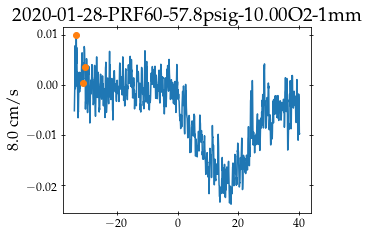

In [50]:
fig,ax = plt.subplots(1,1,sharex=True)
fig.set_size_inches(4,3) 
pci = frames1[title2[0]]
ax.plot(pci.pos.x,pci.data['f430x10h'])
x_flame = pci.x_flame
print(x_flame,pci.T_flame)
v_flame = pci.v_flame
ax.set_title(title2[0].replace('_', '-'))
ax.plot(x_flame,pci.v_flame,'o',linestyle='none')   
ax.set_ylabel(str(v_f1)+' cm/s')
ax.tick_params(labelsize=12)

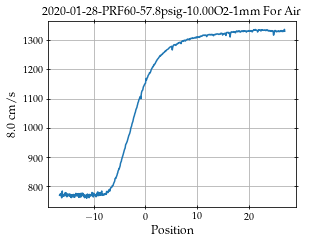

In [51]:
fig,ax = plt.subplots(1,1,sharex=True)
fig.set_size_inches(4,3)
pci = frames1[title2[0]]   
if pci.pyro is not None:      
    ax.plot(pci.pos.x, pci.pos.T)
    ax.grid(True,which='major')
    ax.set_title(title2[0].replace('_', '-')+' For Air',fontsize = 12)
    ax.set_ylabel(str(v_f1)+' cm/s',fontsize = 12)
    ax.set_xlabel('Position',fontsize = 12)
    ax.tick_params(labelsize=10)

In [52]:
def peak(array,a,b):
    c = np.amax(array[a:b])
    d = array.index(np.amax(array[a:b]))
    return c,d

In [53]:
def ext_i(array,low,high):
    c , d  = peak(list(array),low,high)
    j = np.amin(array[low:d])
    nxe = find_nearest_index(array[low:d],j)+low+2
    return nxe

In [54]:
def ign_i(array,low,high):
    c , d  = peak(list(array),low,high)
    j = np.amin(array[d:high])
    nxi = find_nearest_index(array[d:high],j)+d+5
    return nxi

In [55]:
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [56]:
frames2.keys()

dict_keys(['2020_01_28_PRF60_57.8psig_10.00O2_1mm'])

In [57]:
len(test2)

13

### Feature scaling

In [58]:
v_f2

[3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0]

In [59]:
frames2.keys()

dict_keys(['2020_01_28_PRF60_57.8psig_10.00O2_1mm'])

In [60]:
frames2.keys()

dict_keys(['2020_01_28_PRF60_57.8psig_10.00O2_1mm'])

In [61]:
frames1[title2[0]]

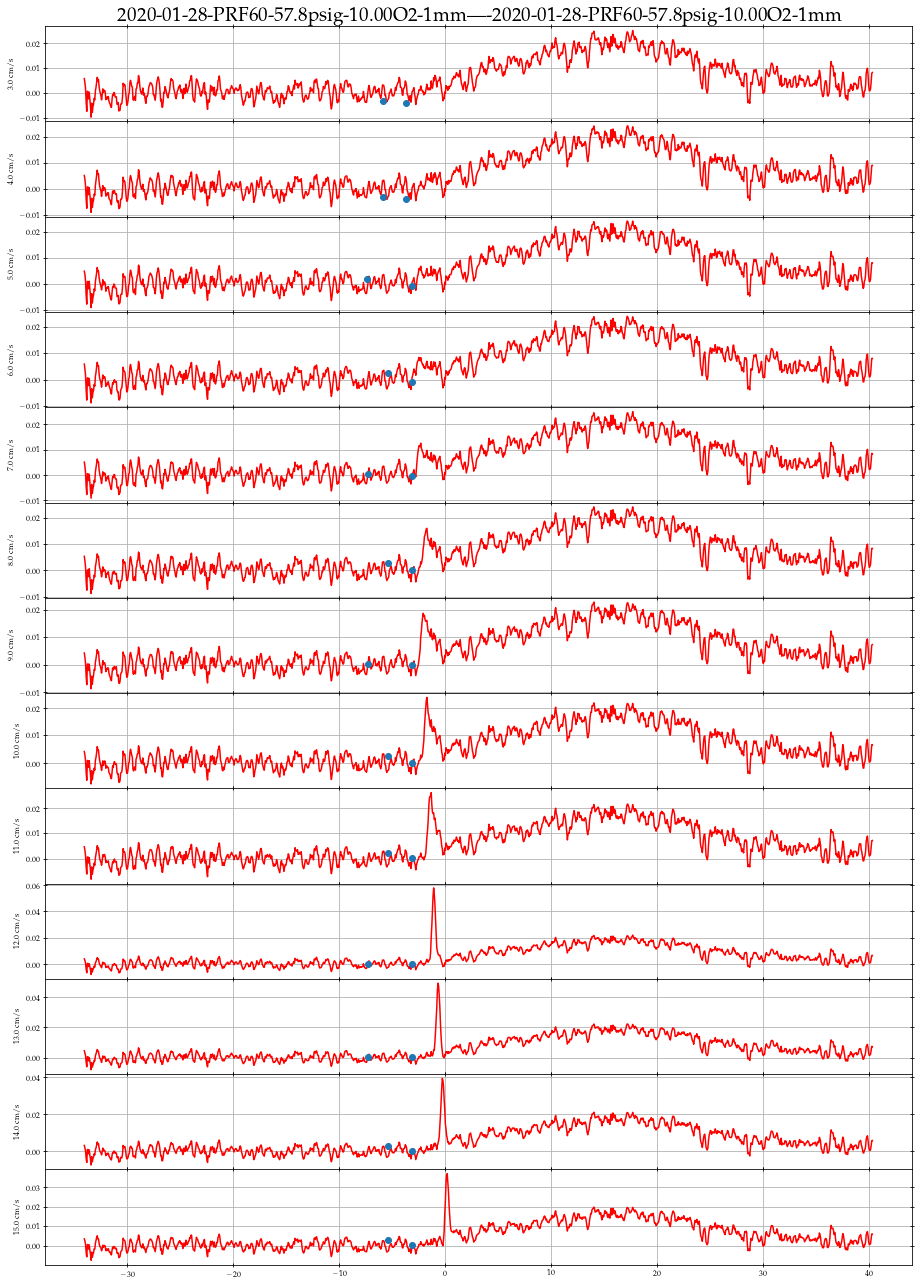

In [62]:
fig,ax = plt.subplots(n_vels2,1,sharex=True)
fig.set_size_inches(14,20)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["figure.dpi"] = 300
xl =-6
xu = 15
wtype = 'rbio3.1'
D_T_V = []
for j in range(n_vels2):
    pci2 = frames2[title2[0]][j]
    pci1 = frames1[title2[0]]
    if pci2.pyro is not None:  
        if v_f2[j] < 5:
            x1 = find_nearest_index(pci1.pos.x,xl)
            x2 = find_nearest_index(pci1.pos.x,xu)
            x_new = pci1.pos.x[x1:x2-1]
            T1_new = pci1.pos.T[x1:x2-1]
            T2_new = pci2.pos.T[x1:x2-1]
            x = pci2.pos.x
            v1= -pci1.data['f430x10h']
            v2 = -pci2.data['f430x10h']
            v3 = v2-v1
            c = ext_i(v2, 482, 505)
            d = ign_i(v2, 490, 520)
            s = [pci2.data['f430x10h'][c],pci2.data['f430x10h'][d]]
            xxx = [pci2.pos.x[c],pci2.pos.x[d]]
            ax[j].plot(x, v2, 'r', xxx,s,'o')
            ax[j].grid(True,which='major')         
            ax[0].set_title(title2[0].replace('_', '-') + '----' + title1[0].replace('_', '-'))
            ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
            ax[j].tick_params(labelsize=8)
        if v_f2[j] >= 5 and v_f2[j]<=15 :
            x1 = find_nearest_index(pci.pos.x,xl)
            x2 = find_nearest_index(pci.pos.x,xu)
            x_new = pci.pos.x[x1:x2-1]
            T1_new = pci1.pos.T[x1:x2-1]
            T2_new = pci2.pos.T[x1:x2-1]
            x = pci2.pos.x
            v1= -pci1.data['f430x10h']
            v2 = -pci2.data['f430x10h']
            v3 = v2-v1
            c = ext_i(v2, 450, 520)
            d = ign_i(v2, 490, 530)
            s = [pci2.data['f430x10h'][c],pci2.data['f430x10h'][d]]
            xxx = [pci2.pos.x[c],pci2.pos.x[d]]
            ax[j].plot(x, v2, 'r', xxx,s,'o')
            ax[j].grid(True,which='major')         
            ax[0].set_title(title2[0].replace('_', '-') + '----' + title1[0].replace('_', '-'))
            ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
            ax[j].tick_params(labelsize=8)
        if v_f2[j] > 15:
            x = pci2.pos.x
            v2 = pci2.data['f430x10h']
            x_flame = pci2.x_flame
            v_flame = pci2.v_flame
            ax[j].plot(x, v2, 'r',x_flame,v_flame,'o')
            ax[j].grid(True,which='major')         
            ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
            ax[j].tick_params(labelsize=8)
        else:
            continue

### Three Ranges for velocity (3ed range uses old code for flame detection)

In [ ]:
fig,ax = plt.subplots(n_vels2,1,sharex=True)
fig.set_size_inches(14,14)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["figure.dpi"] = 300
Tee = []
Tii = []
Te1 = []
Ti1 = []
wtype = 'rbio3.1'
xl = -6.3
xu = 20
ttt = []
for j in range(n_vels2):
    pci2 = frames2[title2[0]][j]
    pci1 = frames1[title2[0]]
    if pci1.pyro is not None and pci2.pyro is not None:  
        if v_f2[j] < 3.6:
            x = pci1.pos.x
            T1= pci1.pos.T
            T2 = pci2.pos.T
            x1 = find_nearest_index(pci1.pos.x,xl)
            x2 = find_nearest_index(pci1.pos.x,xu)
            T1_new = pci1.pos.T[x1:x2-1]
            T2_new = pci2.pos.T[x1:x2-1]
            v1= pci1.data['f430x10h']
            v2 = pci2.data['f430x10h']
            c = ext_i(v2, 482, 505)
            d = ign_i(v2, 490, 520)
            s = [pci1.pos.T[c],pci1.pos.T[d]]
            Tee.append(pci1.pos.T[c])
            Tii.append(pci1.pos.T[d])
            xxx = [pci2.pos.x[c],pci2.pos.x[d]]
            ax[j].plot(x, T1,'b',x,T2,'k',xxx,s,'co')
            ax[j].grid(True,which='major')         
            ax[0].set_title(title2[0].replace('_', '-') + '----' + title1[0].replace('_', '-'))
            ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
            ax[j].tick_params(labelsize=8)
        if v_f2[j] >= 3.6 and v_f2[j]<=5 :
            x = pci1.pos.x
            T1= pci1.pos.T
            T2 = pci2.pos.T
            x1 = find_nearest_index(pci1.pos.x,xl)
            x2 = find_nearest_index(pci1.pos.x,xu)
            T1_new = pci1.pos.T[x1:x2-1]
            T2_new = pci2.pos.T[x1:x2-1]
            v1= pci1.data['f430x10h']
            v2 = pci2.data['f430x10h']
            c = ext_i(v2, 450, 520)
            d = ign_i(v2, 490, 526)
            s = [pci1.pos.T[c],pci1.pos.T[d]]
            Tee.append(pci1.pos.T[c])
            Tii.append(pci1.pos.T[d])
            xxx = [pci2.pos.x[c],pci2.pos.x[d]]
            ax[j].plot(x, T1,'b',x,T2,'k',xxx,s,'co')
            ax[j].grid(True,which='major')         
            ax[0].set_title(title2[0].replace('_', '-') + '----' + title1[0].replace('_', '-'))
            ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
            ax[j].tick_params(labelsize=8)
        if v_f2[j] > 5:
            x = pci1.pos.x
            T1= pci1.pos.T
            T2 = pci2.pos.T
            x1 = find_nearest_index(pci1.pos.x,xl)
            x2 = find_nearest_index(pci1.pos.x,xu)
            T1_new = pci1.pos.T[x1:x2-1]
            T2_new = pci2.pos.T[x1:x2-1]
            x_flame = pci2.x_flame
            T_flame = pci2.T_flame
            x_new = x[x1:x2-1]
            nTm = np.where(pci1.pos.x == pci2.x_flame[0])
            nTp = np.where(pci1.pos.x == pci2.x_flame[2])
            Te = pci1.pos.T[nTm]
            Ti = pci1.pos.T[nTp]
            if not Ti: 
                Tii.append(np.nan)
            else:
                Tii.append(Ti[0])
            if not Te:
                Tee.append(np.nan)
            else:
                Tee.append(Te[0])
            T_air = [Te,Ti]
            x_flame1 = [x_flame[0],x_flame[2]]
            ax[j].plot(x, T1,'b',x_flame1,T_air,'co',x,T2)
            ax[j].grid(True,which='major')         
            ax[0].set_title(title2[0].replace('_', '-') + '----' + title1[0].replace('_', '-'))
            ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
            ax[j].tick_params(labelsize=8)
        else:
            continue

In [ ]:
Tii

In [ ]:
Tee

In [ ]:
plt.plot(v_f2,Tii,'o-',v_f2,Tee)
plt.show()